# Detection of Large-Language Model (LLM) Generated Text

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


2024-07-12 09:38:59.141991: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 09:38:59.142092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 09:38:59.445857: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Загружаем и предобрабртываем данные

In [5]:
data1=pd.read_csv('/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv')
data2=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')

In [6]:
train1_selected = data1[['text', 'label']].copy()

# Selecting necessary columns from train_1 dataset and renaming 'generated' to match the 'label' column
train2_selected = data2[['text', 'generated']].rename(columns={'generated': 'label'}).copy()

# Concatenating the selected columns from both datasets
data = pd.concat([train1_selected, train2_selected], ignore_index=True)

# Displaying the combined data
print(data)

                                                    text  label
0      Phones\n\nModern humans today are always on th...      0
1      This essay will explain if drivers should or s...      0
2      Driving while the use of cellular devices\n\nT...      0
3      Phones & Driving\n\nDrivers should not be able...      0
4      Cell Phone Operation While Driving\n\nThe abil...      0
...                                                  ...    ...
46241  There has been a fuss about the Elector Colleg...      0
46242  Limiting car usage has many advantages. Such a...      0
46243  There's a new trend that has been developing f...      0
46244  As we all know cars are a big part of our soci...      0
46245  Cars have been around since the 1800's and hav...      0

[46246 rows x 2 columns]


In [7]:
# Удаляем дупликаты и нулевые значения
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

# Анализ данных в датасетах

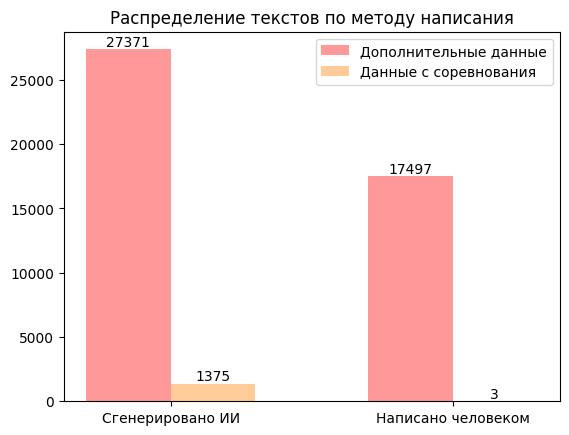

In [44]:
data1_counts = data1['label'].value_counts().reset_index()
data2_counts = data2['generated'].value_counts().reset_index()
index = np.arange(2)

v1 = [data1_counts['count'][0], data1_counts['count'][1]]
v2 = [data2_counts['count'][0], data2_counts['count'][1]]

bw = 0.3
plt.title('Распределение текстов по методу написания')
bars1 = plt.bar(index, v1, bw, color='#FF9999', label='Дополнительные данные')
bars2 = plt.bar(index+bw, v2, bw, color='#FFCC99', label='Данные с соревнования')
plt.xticks(index + 0.5 * bw, ['Сгенерировано ИИ', 'Написано человеком'])
plt.legend()  # Добавление легенды

# Добавление значений на столбцы
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, '%d' % int(height), ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, '%d' % int(height), ha='center', va='bottom')

plt.show()

# Векторизуем текст

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Инициализация TF-IDF векторизатора
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Вы можете настроить max_features по мере необходимости

# Токенизация и создание TF-IDF векторов для столбца 'text' объединенного набора данных
tfidf_vectors = tfidf_vectorizer.fit_transform(data['text'])

# Преобразование TF-IDF векторов в DataFrame для удобного анализа
tfidf_df = pd.DataFrame(tfidf_vectors.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Отображение DataFrame с TF-IDF
print(tfidf_df.head())

    00       000   10  100   11  114  118   12   13   14  ...      your  \
0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
1  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.193019   
2  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
3  0.0  0.060816  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
4  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   

   yours  yourself  youth  youtube  zip  zone  zones  zoos  zygomatic  
0    0.0       0.0    0.0      0.0  0.0   0.0    0.0   0.0        0.0  
1    0.0       0.0    0.0      0.0  0.0   0.0    0.0   0.0        0.0  
2    0.0       0.0    0.0      0.0  0.0   0.0    0.0   0.0        0.0  
3    0.0       0.0    0.0      0.0  0.0   0.0    0.0   0.0        0.0  
4    0.0       0.0    0.0      0.0  0.0   0.0    0.0   0.0        0.0  

[5 rows x 5000 columns]


# Делим датасет на тренировочные и тестовые данные

In [6]:
X = tfidf_df.values 
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Кодируем данные

In [7]:
# Кодирование целевых меток (0 и 1) с использованием LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Архитекрура нейросети

In [23]:
# Создаем модель для нейронной сети
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


# Обучение

In [26]:
history = model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_test, y_test_encoded), verbose=1)

Epoch 1/10
  79/1122 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 1.1773e-04

W0000 00:00:1720696397.471831     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9979 - loss: 0.0066

W0000 00:00:1720696403.982707     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9979 - loss: 0.0066 - val_accuracy: 0.9942 - val_loss: 0.0247
Epoch 2/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9992 - loss: 0.0029 - val_accuracy: 0.9909 - val_loss: 0.0469
Epoch 3/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9992 - loss: 0.0018 - val_accuracy: 0.9940 - val_loss: 0.0406
Epoch 4/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9993 - loss: 0.0021 - val_accuracy: 0.9923 - val_loss: 0.0511
Epoch 5/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9996 - loss: 0.0010 - val_accuracy: 0.9943 - val_loss: 0.0424
Epoch 6/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9997 - loss: 7.6293e-04 - val_accuracy: 0.9941 - val_loss: 0.0443
Epoch 7/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9996 - loss: 9.4033e-04 - val_accuracy: 0.9947 - val_loss: 0.0451
Epoch 8/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9996 - loss: 7.6103e-04 

In [27]:
# Точность на тестовых данных
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy: {test_accuracy:.4f}')

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0548
Test Accuracy: 0.9958


# Сохраняем модель

In [ ]:
import pickle

with open('tfidf_tokenizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

model.save('text_classification_model.h5')


# Usage Code

In [ ]:
import pickle
from tensorflow.keras.models import load_model

# Загружаем токенизатор
with open('tfidf_tokenizer.pkl', 'rb') as f:
    tfidf_tokenizer = pickle.load(f)

# Загружаем модель
loaded_model = load_model('text_classification_model.h5')

# Функция предсказания 
def predict_outcome(text):
    # Предобработка текста с использованием загруженного токенизатора
    text_features = tfidf_tokenizer.transform([text])
    
    # Преобразование текстовых признаков в плотный формат numpy массива
    text_features_dense = text_features.toarray()

    predictions = loaded_model.predict(text_features_dense)
    return predictions[0][0]

In [ ]:
input_text = '''
Some people think that the only way to learn foreign languages is to start very early. Others believe that foreign languages can be learned at any age. In this essay I will address pluses and mines of learning foreign languages at an early age.
 On the one hand, since 4 years children talk with their parents very well. And if in family all speak on 2 languages, child will can speak on 2 languages too. It is the reason, because some people think that studying many languages is simply only at an early age. When I was younger my family often travel to different countries, when people speak in only English. And I learning to speak English to them. It was easy for me.
 On the other hand, many people move to another country. For them they must to learn another language. And they do it. That is an example of how people can learn another language at any age. I think, if people a person really wants to learn something, he can do it.
 In conclusion, somebody think that peoples can learn foreign languages at only an early age, but another think it can be done an any age. I think that everybody is right. All people can to learn foreign languages, but maybe it is easier to do it an early age.
'''


predicted_label = predict_outcome(input_text)
print("Predicted Label:", "{:.20f}".format(predicted_label))

# Делаем предсказание на тестовых данных

In [ ]:
test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
test

In [ ]:
test['generated'] = test['text'].apply(predict_outcome)
submission = test[['id', 'generated']]
submission

In [ ]:
submission.to_csv('submission.csv', index=False)